---
# **Notes**
*`over unstructured data`*
```
RAG Components =
Indexing , Retrieval & Generation (pipeline, actual Chain)

```

```
App Components =
Vector Store, Embdng model, Chatmodel
```

---
## Indexing
`Load (doc loader) -->  Split (textsplitter) --> Store ( Embeddings--> Vector Store)`

## Retrvl & Genrtn
`Question --> Retrieve --> Prompt --> LLM --> Answer`

LangGraph famework to implement

### Index & Store

Use Langgraph - define State, Node, ControlFlow
State = controls Data in q, con, a
Nodes = define Steps (R & G)
CF = Complie app in a  graph object
CustomPrompt using LLM

### Query Analysis

---
# Setup

In [ ]:
# 1. LangChain Dependency Installation
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

# 2. LangSmith
from google.colab import userdata
import os
os.environ["LANGSMITH_TRACING_V2"] = "true"
os.environ["LANGSMITH_API_KEY"] = userdata.get('Smith2')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 12.0 MB/s eta 0:00:00


---
# **Components**

```
Chatmodel, Embedding Model, Vectore Store
```

### Chat model

In [ ]:
!pip install -qU "langchain[google-genai]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [ ]:
from google.colab import userdata

# Retrieve the Gemini API key from Colab's user data
gemini_api_key = userdata.get('gemini')

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai",google_api_key=gemini_api_key)

### Embedding model

In [ ]:
#same gemini

In [ ]:
from google.colab import userdata

# Retrieve the Gemini API key from Colab's user data
gemini_api_key = userdata.get('gemini')

from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=gemini_api_key)

### Vector Store

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

---
# Preview

Create Simple **Indexing Pipeline** and **RAG Chain** in 50 line of code

In [ ]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [ ]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task decomposition is a method of breaking down complex tasks into smaller, simpler steps to improve model performance. It can be achieved through prompting the model to "think step by step" or by using task-specific instructions or human input. This process transforms large tasks into manageable subtasks, providing insight into the model's reasoning.


---


---
# **Detailed Walkthrough**

## 1. Indexing

### Loading Documents

In [ ]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43047


In [ ]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


*--play*

In [ ]:
# Why so many websites are not getting pulled?
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://www.lennysnewsletter.com/p/state-of-the-product-job-market-in",),
    # below wala is not working
    # web_paths=("https://www.scientificamerican.com/article/the-search-for-extraterrestrial-life-as-we-dont-know-it/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs1 = loader.load()

assert len(docs1) == 1
print(f"Total characters: {len(docs1[0].page_content)}")
print(docs1[0].page_content[:500])

Total characters: 225
State of the product job market in 2025There‚Äôs a lot to be optimistic aboutLenny RachitskyMay 13, 2025‚àô Paid173Share this postLenny's NewsletterState of the product job market in 2025Copy linkFacebookEmailNotesMore59Share


### Splitting Documents

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


### Storing Documents

In [ ]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['45946de9-14a5-4a72-b20e-4031384a7c33', '77ea94ff-c908-4b19-a3a5-ad248b1b94c9', '714dd0e7-4a73-408f-be0c-9d92cd8b0a1f']


## 2. Retrieval & Generation

Rag Prompt

In [ ]:
from langchain import hub

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


State

In [ ]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

Node

In [ ]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

ControlFlow

In [ ]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

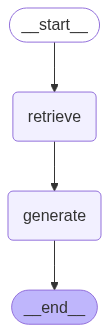

In [ ]:
# Display flow
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

  LangChain Needed?

In [ ]:
question = "What is Task Decomposition?"


retrieved_docs = vector_store.similarity_search(question)
docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
prompt = prompt.invoke({"question": question, "context": docs_content})
answer = llm.invoke(prompt)

AttributeError: 'ChatPromptValue' object has no attribute 'invoke'

#### usage

Invoke

In [ ]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='714dd0e7-4a73-408f-be0c-9d92cd8b0a1f', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1638}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth

Stream Steps (Stream Mode = Updates)

In [ ]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='714dd0e7-4a73-408f-be0c-9d92cd8b0a1f', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1638}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can

Stream Tokens (Stream Mode = messages)

In [ ]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

Task| decomposition is a| method of breaking down complex tasks into smaller, simpler steps. It can be achieved through| techniques like Chain of Thought (CoT) prompting, which instructs a model to "think| step by step". Task decomposition can also be done by LLMs with simple prompting, using task-specific instructions, or with human input.
|

###### Customized Prompt

In [ ]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [ ]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = custom_rag_prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

    from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'ContextCustome: {result["context"]}\n\n')
print(f'AnswerCustom: {result["answer"]}')

ContextCustome: [Document(id='714dd0e7-4a73-408f-be0c-9d92cd8b0a1f', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1638}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (

---
# Query Analysis

Lets add some metadata to late use for filtering

In [ ]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

Define Schema for Search Query

In [ ]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

Graph object rebuild with Query generate step from users raw input

In [ ]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

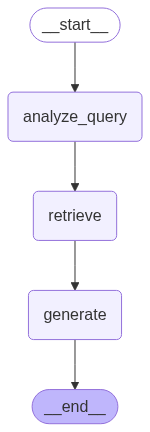

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

Now we can test

In [ ]:
for step in graph.stream(
    {"question": "What does the end of the post say about MVC Component?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'MVC Component', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='b1be33c5-861b-47e2-a463-a36fcc857f3f', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 31986, 'section': 'end'}, page_content='},\n  {\n    "role": "user",\n    "content": "{{There are 10 levels in total. The main character is a plumber named Mario, who can walk and jump. It is a classical platform game just like Super Mario. The main character moves from left to right, trying to get to the destination, where there are many obstacles and attacks from enemies in the process.}}\\n\\nIs anything else unclear? If yes, only answer in the form:\\n{remaining unclear areas} remaining questions.\\n{Next question}\\nIf everything is sufficiently clear, only answer \\"Nothing more to clarify.\\"."\n  },\n  {\n    "role": "assistant",\n    "content": "Remaining unclear areas: 2 remaining questions.\\nCan you provide more inf